# Prediction of surgery vs non-sergery using functional profile

Train machine learning models on sepecies abundance to predict if the sample is from a patient tha has undergone surgery

In [14]:
import numpy as np 
import biom
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [15]:
#load pathway abundance 

df_pathway=pd.read_csv('./data/Filtered_normalized_cpm_pathways_new_unstratified.csv',index_col=0)
df_meta=pd.read_csv('./data/metadata_updated_filtered_201904.csv',index_col=0)

#create dictionary to organize the sample, subjects and their surgery status
dic_surgery=dict(zip(list(df_meta.index),list(df_meta.surgery_type)))
dic_subject=dict(zip(list(df_meta.host_id),list(df_meta.surgery_type)))
dic_sample_host=dict(zip(list(df_meta.index),list(df_meta.host_id)))

## RandomForest classifier for 2 groups: surgery vs no surgery


### Split test and training samples: Separates by subjects
make sure subject in training data does not overlap with subjects in test data

In [4]:
from random import sample 

# Create a lists of subject that have done surgery, and subjects that have not done surgery 

subject_nonsurgery=[i for i in dic_subject.keys() if dic_subject[i]=='none']
subject_surgery=[i for i in dic_subject.keys() if i not in subject_nonsurgery]

# write a function to randomly split test and training set, so that the subjects in test and training do not overlap 
# 70% percent of the subjects are in training samples while 30% subjects are in test samples
def split_data(df_meta,df_pathway):
    #use randome sample to select ~70% subject from each group as training data 
    sub_train_nosurg=sample(subject_nonsurgery,int(len(subject_nonsurgery)*0.7))
    sub_train_surg=sample(subject_surgery,int(len(subject_surgery)*0.7))
    sub_train=sub_train_nosurg+sub_train_surg

    #map subjects back to samples and build the training dataset 
    sample_train=[i for i in df_pathway.columns if dic_sample_host[i] in sub_train]
    sample_test=[i for i in df_pathway.columns if i not in sample_train]
    X_train=df_pathway[sample_train]
    X_test=df_pathway[sample_test]
    
    ## create the output 
    y_train=[]
    for i in X_train.columns: 
        if dic_surgery[i]=='none': 
            y_train.append(0)
        else: 
            y_train.append(1)

    y_test=[]
    for i in X_test.columns: 
        if dic_surgery[i]=='none': 
            y_test.append(0)
        else: 
            y_test.append(1)
    return X_train, X_test,y_test,y_train

X_train, X_test,y_test,y_train=split_data(df_meta,df_pathway)

In [19]:
#train regressor and run it on test data 
from sklearn.ensemble import RandomForestClassifier
class_rf = RandomForestClassifier(n_jobs=4)
class_rf.fit(X_train.T, y_train)

# 10-fold cross validation on the test data 
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(class_rf, X_train.T, y_train, cv=10)
print 'cross-validation on the training data: '
print scores

# Predict on new data
y_rf = class_rf.predict(X_test.T)

# calculate the accuracy score of the classifier 
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score

print 'Prediction accuracy score on the test data: ', accuracy_score(y_test, y_rf) 
average_precision=average_precision_score(y_test, y_rf) 
print 'Average precision-recall score: ', average_precision

cross-validation on the training data: 
[1.         0.90909091 0.80952381 0.75       0.95       0.9
 0.75       0.75       0.85       0.8       ]
Prediction accuracy score on the test data:  0.8526315789473684
Average precision-recall score:  0.8012145748987853


## Randomly split data, train and test the model for 100 times 
### Record ad calculate the average precision-recall score 
### identify the most important pathway that had the highest occurance


In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from numpy import interp
from sklearn.metrics import average_precision_score

#define classifier 
from sklearn.ensemble import RandomForestClassifier
class_rf = RandomForestClassifier(n_jobs=4)
y_test_all=[]
y_rf_all=[]
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
pcscore_list=[]
featuelist=[]
for i in range(100): 
    print i 
    X_train, X_test,y_test,y_train=split_data(df_meta,df_pathway)
    class_rf.fit(X_train.T, y_train)
    # Predict on new data
    y_rf = class_rf.predict_proba(X_test.T)[:, 1]
    #record the y_test and y_rf for each iteration so it could be used to calculate over all precision-recall curve
    y_test_all.append(y_test)
    y_rf_all.append(y_rf)
    # calculate the accuracy score of the classifier 
    pcscore_list.append(average_precision_score(y_test, y_rf))
    ind_top30=sorted(range(len(class_rf.feature_importances_)), key=lambda i: class_rf.feature_importances_[i])[-30:]
    for i in ind_top30: 
        featuelist.append(df_pathway.index[i])
    probas_= class_rf.fit(X_train.T, y_train).predict_proba(X_test.T)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [17]:
# count the most important features that overlapped in 100 runs 
dic_count={}
for s in set(featuelist): 
    count=featuelist.count(s)
    dic_count[s]=count
dic_count

import operator
sorted_x = sorted(dic_count.items(), key=operator.itemgetter(1))
sorted_x

[('GLYCOLYSIS: glycolysis I (from glucose 6-phosphate)', 1),
 ('PWY66-389: phytol degradation', 1),
 ('PWY-5514: UDP-N-acetyl-D-galactosamine biosynthesis II', 1),
 ('PWY490-3: nitrate reduction VI (assimilatory)', 1),
 ('PRPP-PWY: superpathway of histidine, purine, and pyrimidine biosynthesis',
  1),
 ('PWY-7209: superpathway of pyrimidine ribonucleosides degradation', 1),
 ('PWY-7345: superpathway of anaerobic sucrose degradation', 1),
 ('ARGDEG-PWY: superpathway of L-arginine, putrescine, and 4-aminobutanoate degradation',
  1),
 ('TRIGLSYN-PWY: diacylglycerol and triacylglycerol biosynthesis', 1),
 ('PWY-5044: purine nucleotides degradation I (plants)', 1),
 ('PWY0-1479: tRNA processing', 1),
 ('PWY-6731: starch degradation III', 1),
 ('PWY0-321: phenylacetate degradation I (aerobic)', 1),
 ('PWY0-42: 2-methylcitrate cycle I', 1),
 ('ALLANTOINDEG-PWY: superpathway of allantoin degradation in yeast', 1),
 ('PWY-7374: 1,4-dihydroxy-6-naphthoate biosynthesis I', 1),
 ('AEROBACTINSYN-P

### Precision-recall curve

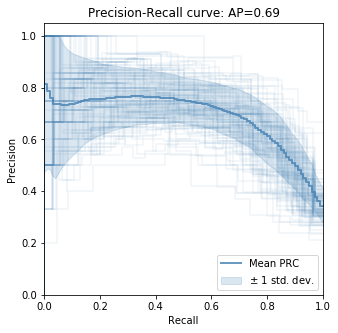

In [26]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
#from inspect import signature

mean_recall = np.linspace(0, 1, 100)
precisions = []

fig = plt.figure()
fig.set_size_inches(5, 5)

for y_test, y_prob in zip(y_test_all, y_rf_all):
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    
    precisions.append(np.interp(mean_recall, recall[::-1], precision[::-1]))
    
    plt.step(recall, precision, color='steelblue', alpha=0.08,
             where='post')
    
mean_precision = np.mean(precisions, axis=0)
    
plt.step(mean_recall, mean_precision, color='steelblue',
         label='Mean PRC',
         lw=2, alpha=.8)

std_precision = np.std(precisions, axis=0)
precision_upper = np.minimum(mean_precision + std_precision, 1)
precision_lower = np.maximum(mean_precision - std_precision, 0)

plt.fill_between(mean_recall, precision_lower, precision_upper, color='steelblue', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: AP={0:0.2f}'.format(
          np.mean(pcscore_list)))

plt.legend(loc="lower right")
plt.savefig('../../../data/Sandborn_data/figures/AUC_ROC_100_iterations_pathway_classification.svg')
plt.savefig('../../../data/Sandborn_data/figures/AUC_ROC_100_iterations_pathway_classification.pdf')
